In [1]:
# Ref. https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html 

In [2]:
!pwd

/home/ivan/Environments/RL/ReinforcementLearningTutorialDQNPyTorch


In [3]:
!ls

DQN_Pytorch_Tutorial.ipynb


In [4]:
import gym

In [5]:
env = gym.make('CartPole-v0').unwrapped

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [6]:
env

In [6]:
type(env)

gym.envs.classic_control.cartpole.CartPoleEnv

In [7]:
import matplotlib
import matplotlib.pyplot as plt

In [8]:
# setting up matplotlib
is_python = 'inline' in matplotlib.get_backend()
if is_python:
    from IPython import display
plt.ion()

In [9]:
import torch

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
device

device(type='cpu')

### We’ll be using experience replay memory for training our DQN

In [12]:
from collections import namedtuple
Transition = namedtuple('Transition',
                       ('state', 'action', 'next_state', 'reward'))

In [13]:
class ReplayMemory():
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [14]:
# remember that a neural networks are universal function approximators, we can simply 
# create one and train it to resemble any function

'''
The main idea behind Q-learning is that if we had a function Q∗: State×Action → ℝ
that could tell us what our return would be, if we were to take an action in a given state,

then we could easily construct a policy that maximizes our rewards:

π∗(s)=argmax wrt:a  for Q∗(s,a)

So we need to build a Q function using NN
'''

'\nThe main idea behind Q-learning is that if we had a function Q∗: State×Action → ℝ\nthat could tell us what our return would be, if we were to take an action in a given state,\n\nthen we could easily construct a policy that maximizes our rewards:\n\nπ∗(s)=argmax wrt:a  for Q∗(s,a)\n\nSo we need to build a Q function using NN\n'

In [15]:
''' 
For our training update rule, we’ll use a fact that every Q function for some policy obeys the Bellman equation:

  Qπ(s,a)=r+γQπ(s′,π(s′))

The difference between the two sides of the equality is known as the temporal difference error, δ

  δ=Q(s,a)−(r+γmaxaQ(s′,a))

To minimise this error, we will use the Huber loss. 
'''

' \nFor our training update rule, we’ll use a fact that every Q function for some policy obeys the Bellman equation:\n\n  Qπ(s,a)=r+γQπ(s′,π(s′))\n\nThe difference between the two sides of the equality is known as the temporal difference error, δ\n\n  δ=Q(s,a)−(r+γmaxaQ(s′,a))\n\nTo minimise this error, we will use the Huber loss. \n'

### building our Q-network

In [16]:
import torch.nn as nn
import torch.nn.functional as F

In [17]:
class DQN(nn.Module):
    
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(448, 2)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

### input extraction

In [18]:
import torchvision.transforms as T
from PIL import Image
import numpy as np

In [19]:
# extracting and processing rendered images from environment to componse image transformations
# Once you run the cell it will display an example patch that it extracted

In [20]:
resize = T.Compose([T.ToPILImage(), T.Resize(40, interpolation=Image.CUBIC), T.ToTensor()])

screen_width = 600 #based on the code from gym

def get_cart_location():
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)

def get_screen():
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    screen = screen[:, 160:320]
    view_width = 320
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width //2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width //2,
                           cart_location + view_width //2)
    screen = screen[:, :, slice_range]
    
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0).to(device)

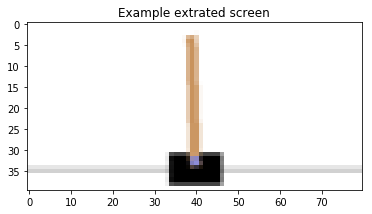

In [21]:
env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), interpolation='none')
plt.title('Example extrated screen')
plt.show()

In [35]:
# env.close() 

### training

In [22]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

In [23]:
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head): Linear(in_features=448, out_features=2, bias=True)
)

In [24]:
import torch.optim as optim

In [25]:
optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)
steps_done = 0

In [26]:
import random, math

In [27]:
def select_actions(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(2)]], device=device, dtype=torch.long)   
    

In [28]:
episode_durations = []

In [29]:
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training......')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
        
    plt.pause(0.001)
    if is_python:
        display.clear_output(wait=True)
        display.display(plt.gcf())

### training loop - training the model

In [30]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, 
                                           batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [31]:
# the main training loop

In [32]:
from itertools import count

In [33]:
num_episodes = 5

for i_episode in range(num_episodes):
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        action = select_actions(state)
        _ , reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        
        last_screen = current_screen
        current_screen = get_screen()
        
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
            
        memory.push(state, action, next_state, reward)
        
        state = next_state
        
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

<Figure size 432x288 with 0 Axes>

Complete


<Figure size 432x288 with 0 Axes>